In [26]:
%config IPCompleter.greedy=True

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from nltk.collocations import *
import nltk
from nltk import FreqDist
import re


import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly.graph_objs as go




from wordcloud import WordCloud

In [27]:
#loading dataset
bd_complaints = "Consumer_Complaints.csv"
df = pd.read_csv(bd_complaints)

C:\Users\Bruno\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [28]:
#Sample dataset
df2 = df.sample(100000)

#df2 = df.copy()

In [29]:
df2.head(2)

Date received                                            Product  \
351614     05/16/2018  Credit reporting, credit repair services, or o...   
1288634    04/22/2013                                        Credit card   

              Sub-product                                 Issue  \
351614   Credit reporting  Incorrect information on your report   
1288634               NaN                              Late fee   

                                   Sub-issue Consumer complaint narrative  \
351614   Information belongs to someone else                          NaN   
1288634                                  NaN                          NaN   

                                   Company public response  \
351614   Company has responded to the consumer and the ...   
1288634                                                NaN   

                                        Company State ZIP code Tags  \
351614   TRANSUNION INTERMEDIATE HOLDINGS, INC.    CA    90303  NaN   
1288634   BANK OF AMERICA, NATIONAL ASSOCIATION    IL    60035  NaN   

        Consumer consent provided? Submitted via Date sent to company  \
351614        Consent not provided           Web           05/16/2018   
1288634                        NaN      Referral           04/24/2013   

        Company response to consumer Timely response? Consumer disputed?  \
351614       Closed with explanation              Yes                NaN   
1288634      Closed with explanation              Yes                 No   

         Complaint ID  
351614        2908447  
1288634        388541

In [30]:
#Transforming date into date object
df2['new_date'] = pd.to_datetime(df2['Date received'], 
                                 format='%m/%d/%Y', 
                                 errors='coerce')
df2['new_date'] = pd.to_datetime(df2['new_date'])


#Extracting year, month, day_name
df2['year'] = pd.DatetimeIndex(df2['new_date']).year
df2['month'] = pd.DatetimeIndex(df2['new_date']).month
df2['month_name'] = pd.DatetimeIndex(df2['new_date']).month_name()
df2['day'] = pd.DatetimeIndex(df2['new_date']).day_name()
df2['day_number'] = pd.DatetimeIndex(df2['new_date']).day

#Counting the number of words of every complaint
df2['len_complaint'] = df2['Consumer complaint narrative'].str.split().str.len()

#Sorting

df2 = df2.sort_values(by=['new_date'],ascending=False)

In [31]:
#Before doing text analysis I will work in  plots with the number of complaints and other stuff

#layout1 = cf.Layout(
#    height=800,
#    width=600
#)

#Number of complaints by day of the week (may be there is some )
df2.groupby('day').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by day of the week', xTitle='Day of the Week', colors='blue' )


In [32]:

#Number of complaints by month, (excluding last year)
df2[df2['year']<2019].groupby('month_name').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by month', xTitle='Month', colors='red' )


In [33]:
#Number of complaints by type of product

df2.groupby('Product').count()['Date received'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.6, title='Number of complaints by Product', xTitle='Product', colors='darkcyan')


In [53]:

#Evolution over the of complaints of the top 4 products


#pivot table, long to wide format

df2_t = pd.pivot_table(df2, values='len_complaint', index=['new_date'],
                   columns=['Product'], aggfunc='count')



df2_t = df2_t[['Credit reporting, credit repair services, or other personal consumer reports','Mortgage','Debt collection','Credit reporting']]


my_fig = df2_t.iplot(subplots=True, 
                     shape=(4,1), 
                     shared_xaxes=True, 
                     fill=True, 
                     asFigure=True,
                     title='Evolution over the time of complaints of the top 4 products')

my_fig.layout.legend=dict(x=-.1, y=-.5)
my_fig.iplot()



In [35]:
#Complaint length histogram


hist_len = df2['len_complaint'].iplot(
            kind='hist',
            bins=400,
            xTitle='complaint length',
            linecolor='black',
            yTitle='count',
            title='Complaint length histogram',
            asFigure=True,
            color='blue')

hist_len.layout.legend=dict(x=-.1, y=-.5)
hist_len.update_xaxes(range=[0, 1000])
hist_len.iplot()



In [36]:
#Boxplot, usefull to identify outliers, and compare medians between products


df_bx = df2[['Product','len_complaint','new_date']]
df_bx= df_bx.dropna()



###Its neccesary to divide the dataset to plot correctly the boxplots:

df_bx_1 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_1['Mortgage'] = df_bx_1['len_complaint']
df_bx_1.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_2 = df_bx.loc[df_bx['Product'] == "Credit reporting, credit repair services, or other personal consumer reports"]
df_bx_2['Credit_report_services'] = df_bx_2['len_complaint']
df_bx_2.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_3 = df_bx.loc[df_bx['Product'] == "Debt collection"]
df_bx_3['Debt collection'] = df_bx_3['len_complaint']
df_bx_3.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_4 = df_bx.loc[df_bx['Product'] == "Credit reporting"]
df_bx_4['Credit reporting'] = df_bx_4['len_complaint']
df_bx_4.drop(['len_complaint', 'Product' ,'new_date'], inplace=True, axis=1)



df_bx_plot = pd.concat([df_bx_1, df_bx_2, df_bx_3, df_bx_4], ignore_index=True, axis=1)


df_bx_plot.rename(columns={0: 'Mortgage', 1: 'Credit_report_services', 2: 'Debt_collection', 3:'Credit_reporting'}, inplace=True)



box_fig = df_bx_plot.iplot(kind='box',
                          asFigure=True,
                          title='Length of the complaints')


box_fig.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig.layout.legend=dict(x=-.1, y=-.5)
box_fig.iplot()


# 2.Text analysis

In [37]:
#There a lot of missing valius into the complaints, in this case it's not possible to impute because it's "free text" data
#For that reason they're going to be delete

#creating a new data set without missing values in the consumer complaint narrative
df3 = df2.copy()
df3 = df3[df3['Consumer complaint narrative'].notnull()]
          
#Counting the number of words of every complaint





# 2.1 Generating an indicator of importance:

In [38]:
###Using regular expressions I will try to identify in every complaint an amount of money
###This ammount of money,may be useful to generate an indicator of importance of the complaint.



#this expression identify money with this struture:
#$xxx.yy xxx.y
#xxx.yy xxx.y
#xxxk

pattern = "(\$[0-9]+\.?[0-9]{1,2}|[0-9]+k)"
df3['money1'] = df3['Consumer complaint narrative'].apply(lambda x: re.findall(pattern, str(x)))

In [39]:
#Transforming the list into a string, astype force the result as astring
df3['money2'] = df3['money1'].apply(lambda x: ' '.join(x)).astype(str)

#Transforming the symbol $ into "" , and k into "000"

df3['money3'] = df3['money2'].str.replace('k','000')
df3['money3'] = df3['money3'].str.replace('$','')

#Now transforming the string into a list to obtein the max:

df3['money4'] = df3['money3'].apply(lambda x: x.split())

#Transforming the elements into float format to correctly detect the max:
df3['money5'] = df3['money4'].apply(lambda x: list(map(float,x)) if len(x)>0 else None)

#Getting the max using a lambda function with a conditional statement
#bbecause if the list have none elements the function max
#will rise an error.

df3['money_max'] = df3['money5'].apply(lambda x: max(x) if x!=None else None)


#### Now plotting the max as boxplot:


In [51]:
#Boxplot, usefull to identify outliers, and compare medians between products


df_bx = df3[['Product','money_max','new_date']]
df_bx= df_bx.dropna()



###Its neccesary to divide the dataset to plot correctly the boxplots:

df_bx_1 = df_bx.loc[df_bx['Product'] == "Mortgage"]
df_bx_1['Mortgage'] = df_bx_1['money_max']
df_bx_1.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_2 = df_bx.loc[df_bx['Product'] == "Credit reporting, credit repair services, or other personal consumer reports"]
df_bx_2['Credit_report_services'] = df_bx_2['money_max']
df_bx_2.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_3 = df_bx.loc[df_bx['Product'] == "Debt collection"]
df_bx_3['Debt collection'] = df_bx_3['money_max']
df_bx_3.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)


df_bx_4 = df_bx.loc[df_bx['Product'] == "Credit reporting"]
df_bx_4['Credit reporting'] = df_bx_4['money_max']
df_bx_4.drop(['money_max', 'Product' ,'new_date'], inplace=True, axis=1)



df_bx_plot = pd.concat([df_bx_1, df_bx_2, df_bx_3, df_bx_4], ignore_index=True, axis=1)


df_bx_plot.rename(columns={0: 'Mortgage', 1: 'Credit_report_services', 2: 'Debt_collection', 3:'Credit_reporting'}, inplace=True)



box_fig = df_bx_plot.iplot(kind='box',
                          asFigure=True,
                          title='Max amount of money detected by complaiment')


box_fig.add_trace(go.Box(
                     name='Only Mean',
                     marker_color='darkblue',
                     boxmean=True))
box_fig.layout.legend=dict(x=-.1, y=-.5)
box_fig.update_yaxes(range=[0, 100000])



box_fig.iplot()

#### Now plotting the max as an average (sum(max)/total_complaints by day)



In [41]:
#Evolution over the of complaints of the top 4 products


#pivot table, long to wide format

df3_t = df3[df3['money_max'].notnull()]

df3_t = pd.pivot_table(df3, values='money_max', index=['new_date'],
                   columns=['Product'], aggfunc='sum')



df3_t = df3_t[['Credit reporting, credit repair services, or other personal consumer reports','Mortgage','Debt collection','Credit reporting']]


my_fig = df3_t.iplot(subplots=True, 
                     shape=(4,1), 
                     shared_xaxes=True, 
                     fill=True, 
                     asFigure=True,
                     title='Evolution over the time of total ammount of the top 4 products')

my_fig.layout.legend=dict(x=-.1, y=-.5)
my_fig.iplot()

# Wordcloud and others:

In [42]:
#Transforming all the complaints into one single string, usefull to do some basic frequency analysis.
all_complains = ' '.join(df3['Consumer complaint narrative'].tolist())
#printing first 2000 words:
all_complains[0:2000]
                         


"this is the final complaint that I am going to issue before going to FBI/ oh attorney general 's office about this company CHEK SYSTEM who keeps committing a crime against me by refusing to update XXXX XXXX XXXX 's who was the Creditors info the credit union has sent to check system a total of 3 TIMES! XXXX stress that chek systems continues to ignore XXXX 's request in WRITTING to mark item PAID in full that is reflecting bad negative item on my credit report! \nI WILL NOT STAND FOR THIS. IT IS COMING TO CIVIL litigation SO BE IT! I NEED THIS TO STOP! THIS IS TOTAL DISCRIMINATION AGAINST me! CHEK SYSTEM once again for the third 3rd time!!!! is refusing to HONOR XXXX XXXX XXXX request in writing. XXXX has informed me mass times by phone and via email ( evidence attached ) that they have contact check system stupid XXXX to let them know thousands of time to make a issue that was solved between the credit union and I PAID request to update my file mass times which is hurting me from ope

In [43]:
#Transforming the text into lowercase 

all_complains_2 = all_complains.lower()

#removing special characters (just keeping text, numbers and dollar symbol)
pattern = '[^a-zA-Z0-9-$]+'
all_complains_2 = re.sub(pattern,' ',all_complains_2)

#printing first 2000 words:
all_complains_2[0:2000]


'this is the final complaint that i am going to issue before going to fbi oh attorney general s office about this company chek system who keeps committing a crime against me by refusing to update xxxx xxxx xxxx s who was the creditors info the credit union has sent to check system a total of 3 times xxxx stress that chek systems continues to ignore xxxx s request in writting to mark item paid in full that is reflecting bad negative item on my credit report i will not stand for this it is coming to civil litigation so be it i need this to stop this is total discrimination against me chek system once again for the third 3rd time is refusing to honor xxxx xxxx xxxx request in writing xxxx has informed me mass times by phone and via email evidence attached that they have contact check system stupid xxxx to let them know thousands of time to make a issue that was solved between the credit union and i paid request to update my file mass times which is hurting me from opening bank accounts i 

In [44]:
#Transforming the words into tokens
complains_token = nltk.word_tokenize(all_complains_2)

#View the top 100 most frequenty words:
fdist1 = FreqDist(complains_token)
fdist1.most_common(10)

[('xxxx', 335148),
 ('the', 257765),
 ('i', 228029),
 ('to', 210249),
 ('and', 169255),
 ('my', 126438),
 ('a', 123820),
 ('of', 104064),
 ('that', 96938),
 ('xx', 88991)]

In [45]:
#removing stop words:


#removing stop words

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 


complains_token_sw = [w for w in complains_token if not w in stop_words]



fdist2 = FreqDist(complains_token_sw)
fdist2.most_common(10)

[('xxxx', 335148),
 ('xx', 88991),
 ('credit', 49938),
 ('account', 42041),
 ('$', 32813),
 ('00', 30742),
 ('report', 21318),
 ('would', 21179),
 ('payment', 20858),
 ('loan', 20035)]

In [46]:
#adding to the original stopwords list

new_stop = ['xxxx' , 'xx' , '$' ,'00' , 'n' ]
stop_words_2 = stop_words.union(new_stop)

complains_token_sw = [w for w in complains_token if not w in stop_words_2]

#Creating text object from new tokenization
complains_textnl = nltk.Text(complains_token_sw)

fdist3 = FreqDist(complains_token_sw)
fdist3.most_common(10)

[('credit', 49938),
 ('account', 42041),
 ('report', 21318),
 ('would', 21179),
 ('payment', 20858),
 ('loan', 20035),
 ('information', 19986),
 ('debt', 17016),
 ('bank', 16863),
 ('told', 16007)]

<Figure size 432x288 with 0 Axes>

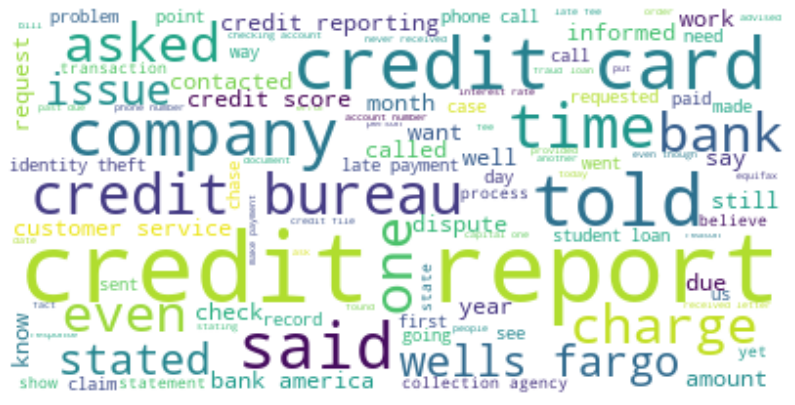

In [47]:
#creating a word cloud

#generating the text without stopwords into one string
text_wc = ' '.join(complains_token_sw)

#Generatig the wordcloud object
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_wc)
#plotting the wordcloud



plt.figure()
plt.figure(figsize = (14, 14), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

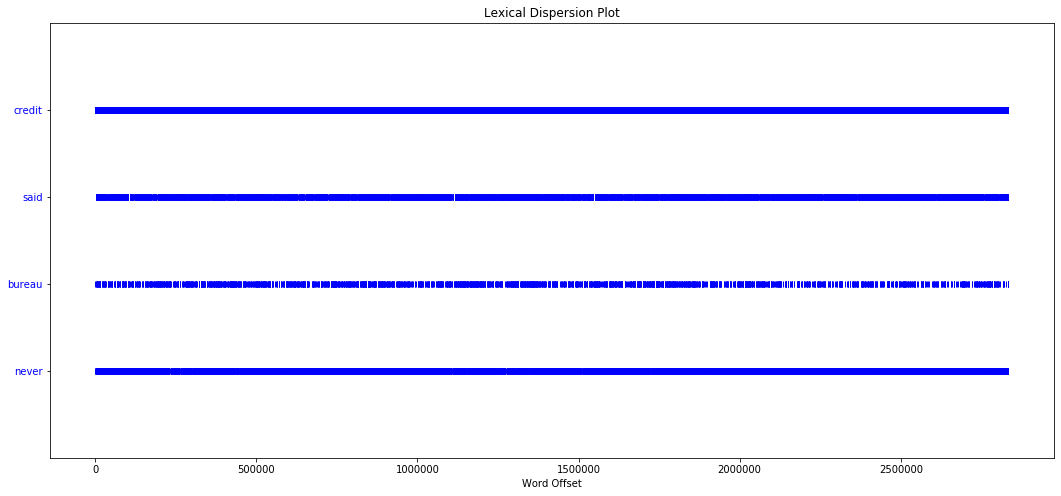

In [48]:
#

plt.figure(figsize = (18, 8), facecolor = None)
complains_textnl.dispersion_plot(['credit','said','bureau','never'])




# Saving notebook into a html file



In [49]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()

jupyter_file = "Pract2.ipynb"
output_html = "Pract2.html"

output_notebook = nbformat.read(jupyter_file, as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_html, 'w', encoding='utf-8').write(output)